# Canny Edge Detector

In [2]:
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import seaborn as sns
import numpy as np
import os
from scipy.ndimage import convolve
from math import pi, sin, cos, tan, exp, sqrt, ceil, floor

In [3]:
dir_path = "C:/Users/gerag/Desktop/Coursera/Fisrt Principles of Computer Vision/Features and Boundaries/Edge Detection Canny/"
im_name = "brick.png"

In [4]:
def plot_img(img, title):
    plt.title(title)
    plt.imshow(img,cmap='gray')
    plt.grid(False)
    plt.axis('off')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.show()

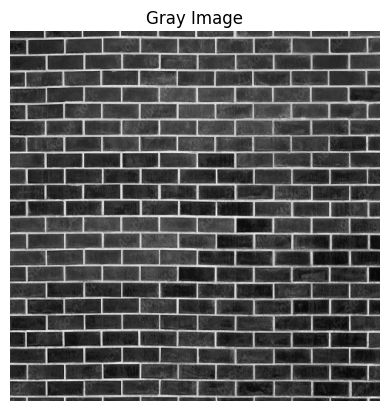

In [5]:
img_color = cv2.imread(dir_path+im_name) #Read image in grey scale
img_color = cv2.resize(img_color, (500,500), interpolation = cv2.INTER_CUBIC)
img = cv2.cvtColor(img_color,cv2.COLOR_BGR2GRAY)
plot_img(img, "Gray Image")

## Steps for Canny algorithm
### 1.- Smooth image with 2D Gaussian filter

$$ \text{2D Gaussian filter kernel:} \hspace{1cm} G(x,y) = \frac{1}{2\pi \sigma^2} e^{ -\frac{x^2 + y^2}{2 \sigma^2} }$$ 


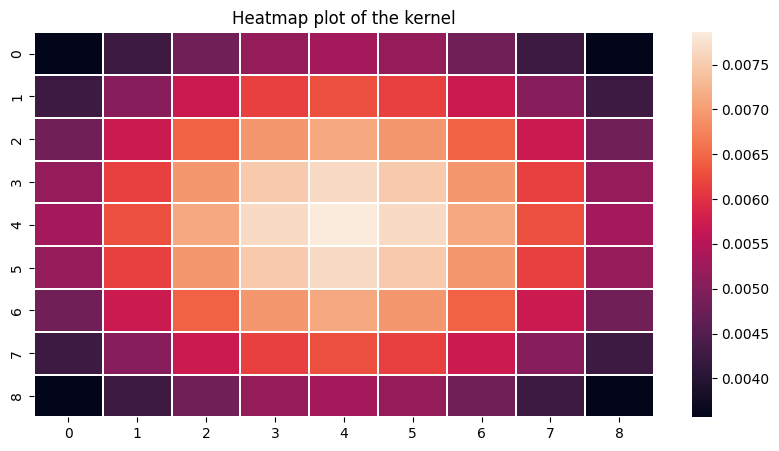

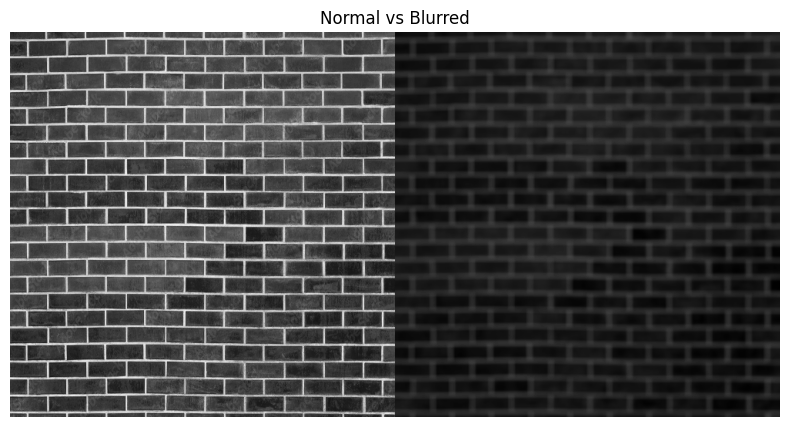

In [6]:
def Gaussian_filter(image :np.array, size :int, sigma : float, verbose = False) -> np.array: 
    k = size//2
    kernel =  np.asarray([[1/(2*pi*sigma**2) * exp( -(i**2+j**2)/(2*sigma**2)) for j in range(-k,k + 1)]  for i in range(-k,k + 1)], dtype="float32")
    filtered = cv2.filter2D(image, -1 , kernel)

    ax = sns.heatmap(kernel, linewidth=0.1)
    plt.title('Heatmap plot of the kernel')
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.show()

    plot_img( np.concatenate((img, filtered), axis = 1), "Normal vs Blurred" )
    #plot_img( filtered, "Blurred" )

    if verbose:
        for row in kernel:
            print(row)
        print("Center: {}".format(kernel[k][k]))
    
    return filtered

blurred = Gaussian_filter(img,size = 9,sigma = 4.5)

### 2.- Compute Image gradient using sobel operator: $\nabla n_{\sigma} \ast I$

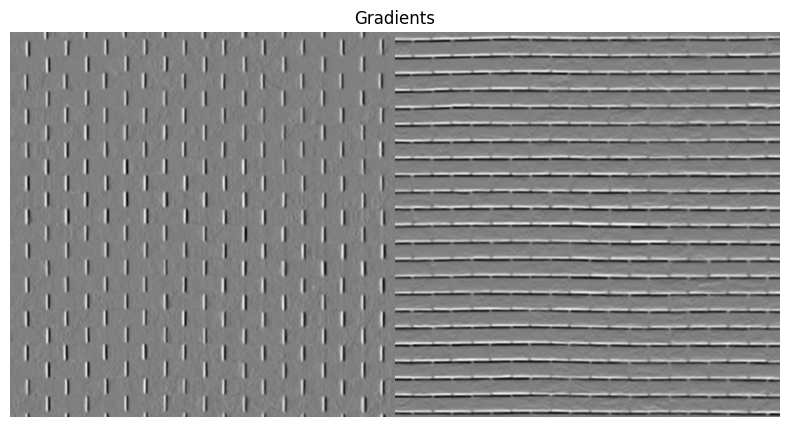

In [7]:
#sobel_3x3_x = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
#sobel_3x3_y = np.array([[1,2,1],[0,0,0],[-1,-2,-1]])

#X_der = cv2.filter2D(blurred, -1, sobel_3x3_x, borderType=cv2.BORDER_CONSTANT) 
#Y_der = cv2.filter2D(blurred, -1, sobel_3x3_y, borderType=cv2.BORDER_CONSTANT) 


X_der = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=1, dy=0, ksize=7)
Y_der = cv2.Sobel(src=img, ddepth=cv2.CV_64F, dx=0, dy=1, ksize=7)

plot_img(np.concatenate((X_der,Y_der),axis = 1),"Gradients")

### 3.- Find the magnitude and orientation 
$\nabla$ Magnitude: $\hspace{3cm} S = ||\nabla I|| = \sqrt{\left(\frac{\partial I}{\partial x} \right)^2 + \left(\frac{\partial I}{\partial y} \right)^2} $

$\nabla$ Orientation: $\hspace{3cm} \theta = \tan^{-1} \left( \frac{ \frac{\partial I}{\partial y}  }{\frac{\partial I}{\partial x}} \right)$

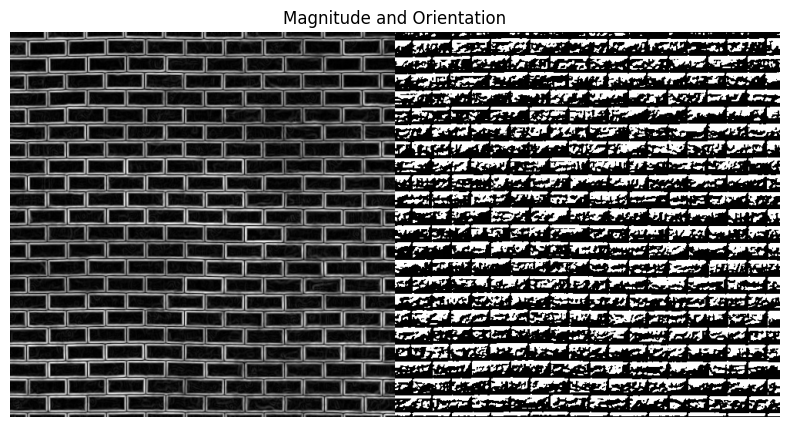

255.0


In [8]:
Magnitude = np.sqrt( X_der**2 + Y_der**2 )
Magnitude = Magnitude / Magnitude.max() * 255

Orientation = np.arctan2(Y_der,X_der)

plot_img( np.concatenate((Magnitude.astype('uint8'),Orientation.astype('uint8')),axis=1)      ,"Magnitude and Orientation")
print(np.max(Magnitude))

### 5.- Compute laplacian along Gradient direction $\hat{n}$ at each pixel   $\frac{\partial^2 (n_\sigma \ast I)}{\partial \hat{n}^2}$

It's done by using the Non-Maximum Supression(NMS) algorithm:
1. For each pixel, we select two of its neighbors based on the direction of the gradient.
<img src="eq_1.png" 
        alt="Picture" 
        style="display: block; margin: 0 auto" />
2. As a next step, we compare the strength of the current pixel with the other two ($S(p)$ stands for Magnitude in current pixel).
 $$ S(p1) < S(p) > S(p2) $$
   If the pixel magnitude is lower than one of the both neighbors suppress it by making it zero (black/background).
   
   Otherwise keep it unchanged and proceed with the next one.


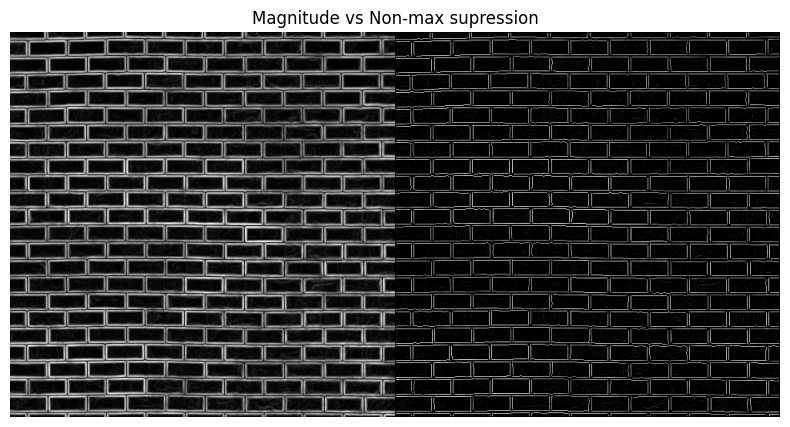

In [9]:
f,c = img.shape

NMS = np.zeros_like(Magnitude)

angle = np.rad2deg(Orientation)
angle[angle < 0] += 180

for i in range(1,f-1):
    for j in range(1,c-1):
        
        #Angle 0 or 180: 0 - 22.5 and 157.5 - 180
        if( 0 <= angle[i][j] < 22.5) or ( 157.5 <= angle[i][j] < 180):
            if(Magnitude[i][j] >= Magnitude[i][j + 1]) and (Magnitude[i][j] >= Magnitude[i][j - 1]):
                NMS[i][j] = Magnitude[i][j]
            else:
                NMS[i][j] = 0

        #Angle 45: 22.5 - 67.5
        elif( 22.5 <= angle[i][j] < 67.5):
            if(Magnitude[i][j] >= Magnitude[i-1][j + 1]) and (Magnitude[i][j] >= Magnitude[i + 1][j - 1]):
                NMS[i][j] = Magnitude[i][j]
            else:
                NMS[i][j] = 0
        
        #Angle 90: 67.5 - 112.5
        elif( 67.5 <= angle[i][j] < 112.5):
            if(Magnitude[i][j] >= Magnitude[i-1][j]) and (Magnitude[i][j] >= Magnitude[i + 1][j]):
                NMS[i][j] = Magnitude[i][j]
            else:
                NMS[i][j] = 0
        
        #Angle 135: 112.5 - 157.5
        elif( 112.5 <= angle[i][j] < 135.5):
            if(Magnitude[i][j] >= Magnitude[i-1][j-1]) and (Magnitude[i][j] >= Magnitude[i + 1][j + 1]):
                NMS[i][j] = Magnitude[i][j]
            else:
                NMS[i][j] = 0


plot_img(np.concatenate( (Magnitude.astype('uint8'),NMS.astype('uint8')) , axis = 1),"Magnitude vs Non-max supression")


### Edge Thresholding 
#### Hysteresis Based

In [10]:
moves = [[-1, 0],
         [-1, 1],
         [0, 1],
         [1, 1],
         [1, 0],
         [1, -1],
         [0, -1],
         [-1, -1]]

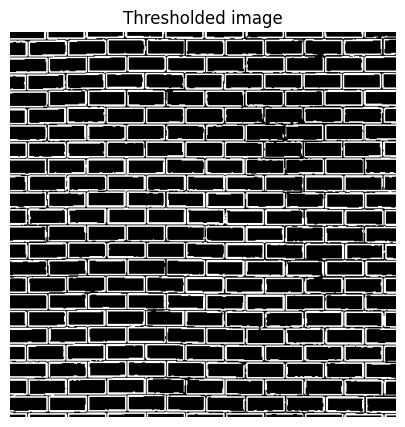

In [11]:
T0 = 100
T1 = 180


threshold = np.zeros_like(img)

for i in range(f):
    for j in range(c):

        if Magnitude[i][j] < T0:
            threshold[i][j] = 0
        elif Magnitude[i][j] >= T1:
            threshold[i][j] = 255
        else: #T0<= Magnitude[i][j] < T1
            for move in moves:
                if i+move[0] < f and j+move[1] < c and i+move[0] > 0 and j+move[1] > 0:
                    if T0 <= Magnitude[i+move[0]][j+move[1]] < T1:
                        threshold[i][j] = 255
                        
plot_img(threshold,"Thresholded image")

## OpenCv Function

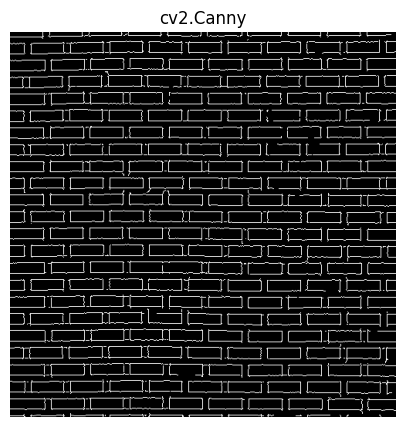

In [12]:
# Canny Edge Detection
edges = cv2.Canny(image=blurred, threshold1=30, threshold2=40)
plot_img(edges, "cv2.Canny")